# Flow of documentation:
## Section 0.X : Describes all the codes necessary to get the data loaded, transformed both with and without deep learning to fetch prediction
## Section 1.X : Describes details of the code that is responsible to execute this visualization

# 0.1 Export needed libraries

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import sys
from yacs.config import CfgNode as CN
import os
from PIL import Image 
import torch
from torch.utils.data import Dataset
from torchvision import transforms, datasets
import numpy as np
import os
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torchvision import transforms
#from cityscapesscripts.helpers.labels import trainId2label as t2l
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from einops import rearrange
import shutil
import time
import tqdm
from csv import reader
from functools import reduce
import torchvision
import torch._utils
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import numpy as np
import math
from torchvision import models
import progressbar
from time import sleep
from pathlib import Path
import csv
import itertools
import random
import gc
import statistics
import pandas as pd
import logging
import functools
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet50
import requests
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from matplotlib.widgets import Button

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
from pytorch_grad_cam import GradCAM
from textwrap import wrap
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet50
import torch
import numpy as np
import requests
import torchvision
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

# 0.2 Defining variables

In [3]:
ROOT_DIR = '/home/sourajit/DeepLearningProjects/data/cityscapes'
IMG_HEIGHT = 512  
IMG_WIDTH = 1024
ORIGINAL_IMG_HEIGHT = 1024  
ORIGINAL_IMG_WIDTH = 2048
BATCH_SIZE = 1
LEARNING_RATE = 0.0005
EPOCHS = 10
GLOBAL_EPOCH_COUNTER = 0
MAX_ITER = 3000000
NUM_WORKERS = 0
NUM_CLASSES = 19
ignore_label = 255
BatchNorm2d = nn.BatchNorm2d
BN_MOMENTUM = 0.01
ALIGN_CORNERS = True
logger = logging.getLogger(__name__)
device_rtx3090 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_rtx3070 = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# 0.3 Introducing Deep Learning Models to make predictions

In [4]:
BatchNorm2d = nn.BatchNorm2d
BN_MOMENTUM = 0.01
ALIGN_CORNERS = True
logger = logging.getLogger(__name__)

In [5]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

In [6]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [7]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion,
                               momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [8]:
class HighResolutionModule(nn.Module):
    def __init__(self, num_branches, blocks, num_blocks, num_inchannels,
                 num_channels, fuse_method, multi_scale_output=True):
        super(HighResolutionModule, self).__init__()
        self._check_branches(
            num_branches, blocks, num_blocks, num_inchannels, num_channels)

        self.num_inchannels = num_inchannels
        self.fuse_method = fuse_method
        self.num_branches = num_branches

        self.multi_scale_output = multi_scale_output

        self.branches = self._make_branches(
            num_branches, blocks, num_blocks, num_channels)
        self.fuse_layers = self._make_fuse_layers()
        self.relu = nn.ReLU(inplace=True)

    def _check_branches(self, num_branches, blocks, num_blocks,
                        num_inchannels, num_channels):
        if num_branches != len(num_blocks):
            error_msg = 'NUM_BRANCHES({}) <> NUM_BLOCKS({})'.format(
                num_branches, len(num_blocks))
            logger.error(error_msg)
            raise ValueError(error_msg)

        if num_branches != len(num_channels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_CHANNELS({})'.format(
                num_branches, len(num_channels))
            logger.error(error_msg)
            raise ValueError(error_msg)

        if num_branches != len(num_inchannels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_INCHANNELS({})'.format(
                num_branches, len(num_inchannels))
            logger.error(error_msg)
            raise ValueError(error_msg)

    def _make_one_branch(self, branch_index, block, num_blocks, num_channels,
                         stride=1):
        downsample = None
        if stride != 1 or \
           self.num_inchannels[branch_index] != num_channels[branch_index] * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.num_inchannels[branch_index],
                          num_channels[branch_index] * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(num_channels[branch_index] * block.expansion,
                            momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(self.num_inchannels[branch_index],
                            num_channels[branch_index], stride, downsample))
        self.num_inchannels[branch_index] = \
            num_channels[branch_index] * block.expansion
        for i in range(1, num_blocks[branch_index]):
            layers.append(block(self.num_inchannels[branch_index],
                                num_channels[branch_index]))

        return nn.Sequential(*layers)

    def _make_branches(self, num_branches, block, num_blocks, num_channels):
        branches = []

        for i in range(num_branches):
            branches.append(
                self._make_one_branch(i, block, num_blocks, num_channels))

        return nn.ModuleList(branches)

    def _make_fuse_layers(self):
        if self.num_branches == 1:
            return None

        num_branches = self.num_branches
        num_inchannels = self.num_inchannels
        fuse_layers = []
        for i in range(num_branches if self.multi_scale_output else 1):
            fuse_layer = []
            for j in range(num_branches):
                if j > i:
                    fuse_layer.append(nn.Sequential(
                        nn.Conv2d(num_inchannels[j],
                                  num_inchannels[i],
                                  1,
                                  1,
                                  0,
                                  bias=False),
                        BatchNorm2d(num_inchannels[i], momentum=BN_MOMENTUM)))
                elif j == i:
                    fuse_layer.append(None)
                else:
                    conv3x3s = []
                    for k in range(i-j):
                        if k == i - j - 1:
                            num_outchannels_conv3x3 = num_inchannels[i]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                BatchNorm2d(num_outchannels_conv3x3, 
                                            momentum=BN_MOMENTUM)))
                        else:
                            num_outchannels_conv3x3 = num_inchannels[j]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                BatchNorm2d(num_outchannels_conv3x3,
                                            momentum=BN_MOMENTUM),
                                nn.ReLU(inplace=True)))
                    fuse_layer.append(nn.Sequential(*conv3x3s))
            fuse_layers.append(nn.ModuleList(fuse_layer))

        return nn.ModuleList(fuse_layers)

    def get_num_inchannels(self):
        return self.num_inchannels

    def forward(self, x):
        if self.num_branches == 1:
            return [self.branches[0](x[0])]

        for i in range(self.num_branches):
            x[i] = self.branches[i](x[i])

        x_fuse = []
        for i in range(len(self.fuse_layers)):
            y = x[0] if i == 0 else self.fuse_layers[i][0](x[0])
            for j in range(1, self.num_branches):
                if i == j:
                    y = y + x[j]
                elif j > i:
                    width_output = x[i].shape[-1]
                    height_output = x[i].shape[-2]
                    y = y + F.upsample(
                        self.fuse_layers[i][j](x[j]),
                        size=[height_output, width_output],
                        mode='bilinear')
                else:
                    y = y + self.fuse_layers[i][j](x[j])
            x_fuse.append(self.relu(y))

        return x_fuse


In [9]:
blocks_dict = {
    'BASIC': BasicBlock,
    'BOTTLENECK': Bottleneck
}

In [10]:
HIGH_RESOLUTION_NET = CN()
HIGH_RESOLUTION_NET.PRETRAINED_LAYERS = ['*']
HIGH_RESOLUTION_NET.STEM_INPLANES = 64
HIGH_RESOLUTION_NET.FINAL_CONV_KERNEL = 1
HIGH_RESOLUTION_NET.WITH_HEAD = True

HIGH_RESOLUTION_NET.STAGE1 = CN()
HIGH_RESOLUTION_NET.STAGE1.NUM_MODULES = 1
HIGH_RESOLUTION_NET.STAGE1.NUM_BRANCHES = 1
HIGH_RESOLUTION_NET.STAGE1.NUM_BLOCKS = [4]
HIGH_RESOLUTION_NET.STAGE1.NUM_CHANNELS = [64]
HIGH_RESOLUTION_NET.STAGE1.BLOCK = 'BOTTLENECK'
HIGH_RESOLUTION_NET.STAGE1.FUSE_METHOD = 'SUM'

HIGH_RESOLUTION_NET.STAGE2 = CN()
HIGH_RESOLUTION_NET.STAGE2.NUM_MODULES = 1
HIGH_RESOLUTION_NET.STAGE2.NUM_BRANCHES = 2
HIGH_RESOLUTION_NET.STAGE2.NUM_BLOCKS = [4, 4]
HIGH_RESOLUTION_NET.STAGE2.NUM_CHANNELS = [48, 96]
HIGH_RESOLUTION_NET.STAGE2.BLOCK = 'BASIC'
HIGH_RESOLUTION_NET.STAGE2.FUSE_METHOD = 'SUM'

HIGH_RESOLUTION_NET.STAGE3 = CN()
HIGH_RESOLUTION_NET.STAGE3.NUM_MODULES = 4
HIGH_RESOLUTION_NET.STAGE3.NUM_BRANCHES = 3
HIGH_RESOLUTION_NET.STAGE3.NUM_BLOCKS = [4, 4, 4]
HIGH_RESOLUTION_NET.STAGE3.NUM_CHANNELS = [48, 96, 192]
HIGH_RESOLUTION_NET.STAGE3.BLOCK = 'BASIC'
HIGH_RESOLUTION_NET.STAGE3.FUSE_METHOD = 'SUM'

HIGH_RESOLUTION_NET.STAGE4 = CN()
HIGH_RESOLUTION_NET.STAGE4.NUM_MODULES = 3
HIGH_RESOLUTION_NET.STAGE4.NUM_BRANCHES = 4
HIGH_RESOLUTION_NET.STAGE4.NUM_BLOCKS = [4, 4, 4, 4]
HIGH_RESOLUTION_NET.STAGE4.NUM_CHANNELS = [48, 96, 192, 384]
HIGH_RESOLUTION_NET.STAGE4.BLOCK = 'BASIC'
HIGH_RESOLUTION_NET.STAGE4.FUSE_METHOD = 'SUM'

DATASET = CN()
DATASET.ROOT = ''
DATASET.DATASET = 'cityscapes'
DATASET.NUM_CLASSES = 19
DATASET.TRAIN_SET = 'list/cityscapes/train.lst'
DATASET.EXTRA_TRAIN_SET = ''
DATASET.TEST_SET = 'list/cityscapes/val.lst'

MODEL = CN()
MODEL.NAME = 'seg_hrnet'
MODEL.PRETRAINED = '/home/sourajit/DeepLearningProjects/Research_2.0/hrnet_cs_8090_torch11.pth'
MODEL.ALIGN_CORNERS = True
MODEL.NUM_OUTPUTS = 1
MODEL.EXTRA = CN(new_allowed=True)

In [11]:
class HighResolutionNet(nn.Module):

    def __init__(self, model_config=None, dataset_config=None):
        model_config = model_config
        dataset_config = dataset_config
        super(HighResolutionNet, self).__init__()

        # stem net
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn1 = BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn2 = BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        
        self.stage1_cfg = model_config['STAGE1']
        num_channels = self.stage1_cfg['NUM_CHANNELS'][0]
        block = blocks_dict[self.stage1_cfg['BLOCK']]
        num_blocks = self.stage1_cfg['NUM_BLOCKS'][0]
        self.layer1 = self._make_layer(block, 64, num_channels, num_blocks)
        stage1_out_channel = block.expansion*num_channels

        self.stage2_cfg = model_config['STAGE2']
        num_channels = self.stage2_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage2_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition1 = self._make_transition_layer(
            [stage1_out_channel], num_channels)
        self.stage2, pre_stage_channels = self._make_stage(
            self.stage2_cfg, num_channels)

        self.stage3_cfg = model_config['STAGE3']
        num_channels = self.stage3_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage3_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition2 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage3, pre_stage_channels = self._make_stage(
            self.stage3_cfg, num_channels)

        self.stage4_cfg = model_config['STAGE4']
        num_channels = self.stage4_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage4_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition3 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage4, pre_stage_channels = self._make_stage(
            self.stage4_cfg, num_channels, multi_scale_output=True)
        
        last_inp_channels = int(np.sum(pre_stage_channels))
        self.last_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=last_inp_channels,
                kernel_size=1,
                stride=1,
                padding=0),
            BatchNorm2d(last_inp_channels, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=dataset_config.NUM_CLASSES,
                kernel_size=model_config.FINAL_CONV_KERNEL,
                stride=1,
                padding=1 if model_config.FINAL_CONV_KERNEL == 3 else 0)
        )

    def _make_transition_layer(
            self, num_channels_pre_layer, num_channels_cur_layer):
        num_branches_cur = len(num_channels_cur_layer)
        num_branches_pre = len(num_channels_pre_layer)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(nn.Sequential(
                        nn.Conv2d(num_channels_pre_layer[i],
                                  num_channels_cur_layer[i],
                                  3,
                                  1,
                                  1,
                                  bias=False),
                        BatchNorm2d(
                            num_channels_cur_layer[i], momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=True)))
                else:
                    transition_layers.append(None)
            else:
                conv3x3s = []
                for j in range(i+1-num_branches_pre):
                    inchannels = num_channels_pre_layer[-1]
                    outchannels = num_channels_cur_layer[i] \
                        if j == i-num_branches_pre else inchannels
                    conv3x3s.append(nn.Sequential(
                        nn.Conv2d(
                            inchannels, outchannels, 3, 2, 1, bias=False),
                        BatchNorm2d(outchannels, momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=True)))
                transition_layers.append(nn.Sequential(*conv3x3s))

        return nn.ModuleList(transition_layers)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)

    def _make_stage(self, layer_config, num_inchannels,
                    multi_scale_output=True):
        num_modules = layer_config['NUM_MODULES']
        num_branches = layer_config['NUM_BRANCHES']
        num_blocks = layer_config['NUM_BLOCKS']
        num_channels = layer_config['NUM_CHANNELS']
        block = blocks_dict[layer_config['BLOCK']]
        fuse_method = layer_config['FUSE_METHOD']

        modules = []
        for i in range(num_modules):
            # multi_scale_output is only used last module
            if not multi_scale_output and i == num_modules - 1:
                reset_multi_scale_output = False
            else:
                reset_multi_scale_output = True
            modules.append(
                HighResolutionModule(num_branches,
                                      block,
                                      num_blocks,
                                      num_inchannels,
                                      num_channels,
                                      fuse_method,
                                      reset_multi_scale_output)
            )
            num_inchannels = modules[-1].get_num_inchannels()

        return nn.Sequential(*modules), num_inchannels

    def forward(self, x):
        out_h, out_w = x.size(2), x.size(3)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        #print ("After first few: ", x.shape)
        x = self.layer1(x)
        #print ("After stage 1: ", x.shape)
        x_list = []
        for i in range(self.stage2_cfg['NUM_BRANCHES']):
            if self.transition1[i] is not None:
                x_list.append(self.transition1[i](x))
            else:
                x_list.append(x)
        y_list = self.stage2(x_list)
        #for idx in range(len(y_list)):
            #print ("After stage 2: ", y_list[idx].shape)
        x_list = []
        for i in range(self.stage3_cfg['NUM_BRANCHES']):
            if self.transition2[i] is not None:
                x_list.append(self.transition2[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage3(x_list)
        #for idx in range(len(y_list)):
            #print ("After stage 3: ", y_list[idx].shape)
        x_list = []
        for i in range(self.stage4_cfg['NUM_BRANCHES']):
            if self.transition3[i] is not None:
                x_list.append(self.transition3[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        x = self.stage4(x_list)
        #for idx in range(len(x)):
            #print ("After stage 4: ", x[idx].shape)
        # Upsampling
        x0_h, x0_w = x[0].size(2), x[0].size(3)
        #print ("..........", x0_h, x0_w)
        x1 = F.upsample(x[1], size=(x0_h, x0_w), mode='bilinear',
                        align_corners=ALIGN_CORNERS)
        #print ("After upsample1: ", x1.shape)
        x2 = F.upsample(x[2], size=(x0_h, x0_w), mode='bilinear',
                        align_corners=ALIGN_CORNERS)
        #print ("After upsample2: ", x2.shape)
        x3 = F.upsample(x[3], size=(x0_h, x0_w), mode='bilinear',
                        align_corners=ALIGN_CORNERS)
        #print ("After upsample3: ", x3.shape)
        x = torch.cat([x[0], x1, x2, x3], 1)
        #print ("After cat: ", x.shape)
        x = self.last_layer(x)
        #print ("After the very last layer: ", x.shape)
        x = F.upsample(x, size=(out_h, out_w), mode='bilinear', align_corners=ALIGN_CORNERS)
        #print ("After final upsampling: ", x.shape)
        return x

    def init_weights(self, pretrained='',):
        logger.info('=> init weights from normal distribution')
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if os.path.isfile(pretrained):
            pretrained_dict = torch.load(pretrained)
            #print (len(pretrained_dict))
            logger.info('=> loading pretrained model {}'.format(pretrained))
            model_dict = self.state_dict()
            pretrained_dict = {k: v for k, v in pretrained_dict.items()
                               if k in model_dict.keys()}
            #for k, _ in pretrained_dict.items():
            #    logger.info(
            #        '=> loading {} pretrained model {}'.format(k, pretrained))
            model_dict.update(pretrained_dict)
            self.load_state_dict(model_dict)

In [12]:
def get_seg_model(HIGH_RESOLUTION_NET, DATASET):
    #model = HighResolutionNetv1(model_config=HIGH_RESOLUTION_NET, dataset_config=DATASET)
    model = HighResolutionNet(model_config=HIGH_RESOLUTION_NET, dataset_config=DATASET)
    model.init_weights(MODEL.PRETRAINED)
    return model

# 0.4 Checking if an dataset instance is from train/val/test split

In [13]:
def checker(filename):
    filename = str(filename)
    data_type = None
    if (filename == 'None'):
        data_type = 'Train Set'
    elif (filename.startswith("['/frankfurt") or
         filename.startswith("['/lindau") or
         filename.startswith("['/munster")):
        data_type = 'Val Set'
    else:
        data_type = 'Test Set'
    return data_type

# 0.5 Auxiliary function to save PIL images in disk

In [14]:
def save_as_images(tensor_pred, folder, image_name):
    tensor_pred = transforms.ToPILImage()(255*tensor_pred[0].type(torch.FloatTensor))
    filename = f"{folder}/{image_name}.png"
    tensor_pred.save(filename)

# 0.6 Auxiliary function to compute average of a list

In [15]:
def Average(lst):
    return reduce(lambda a, b: a + b, lst) / len(lst)

# 0.7 Cityscapes class ID to color maping before merging classes

In [16]:
color_mapping_before_conversion = {
     0 : (  0,  0,  0),
     1 : (  0,  0,  0),
     2 : (  0,  0,  0),
     3 : (  0,  0,  0),
     4 : (  0,  0,  0),
     5 : (111, 74,  0),
     6 : ( 81,  0, 81),
     7 : (128, 64,128),
     8 : (244, 35,232),
     9 : (250,170,160),
    10 : (230,150,140),
    11 : ( 70, 70, 70),
    12 : (102,102,156),
    13 : (190,153,153),
    14 : (180,165,180),
    15 : (150,100,100),
    16 : (150,120, 90),
    17 : (153,153,153),
    18 : (153,153,153),
    19 : (250,170, 30),
    20 : (220,220,  0),
    21 : (107,142, 35),
    22 : (152,251,152),
    23 : ( 70,130,180),
    24 : (220, 20, 60),
    25 : (255,  0,  0),
    26 : (  0,  0,142),
    27 : (  0,  0, 70),
    28 : (  0, 60,100),
    29 : (  0,  0, 90),
    30 : (  0,  0,110),
    31 : (  0, 80,100),
    32 : (  0,  0,230),
    33 : (119, 11, 32),
    -1 : (  0,  0,142)
}

# 0.8 Cityscapes class ID to color maping after merging classes

In [17]:
color_mapping_after_conversion = {
     255 : (  0,  0,  0),
     0 : (128, 64,128),
     1 : (244, 35,232),
     2 : ( 70, 70, 70),
     3 : (102,102,156),
     4 : (190,153,153),
     5 : (153,153,153),
     6 : (250,170, 30),
     7 : (220,220,  0),
     8 : (107,142, 35),
     9 : (152,251,152),
    10 : ( 70,130,180),
    11 : (220, 20, 60),
    12 : (255,  0,  0),
    13 : (  0,  0,142),
    14 : (  0,  0, 70),
    15 : (  0, 60,100),
    16 : (  0, 80,100),
    17 : (  0,  0,230),
    18 : (119, 11, 32)
}

# 0.9 ID to class name mapping

In [18]:
id2class_after_conversion = {
     255 : "unlabeled",
     0 : "road",
     1 : "sidewalk",
     2 : "building",
     3 : "wall",
     4 : "fence",
     5 : "pole",
     6 : "tr. light",
     7 : "tr. sign",
     8 : "veg.",
     9 : "terrain",
    10 : "sky",
    11 : "person",
    12 : "rider",
    13 : "car",
    14 : "truck",
    15 : "bus",
    16 : "train",
    17 : "m. cycle",
    18 : "bicycle"
}

# 0.10 drawing predefined colors on mask of any object with a corresponding segmentation mask

In [19]:
def label2color(label, color_array):
    temp = label.clone()
    label1 = label.clone()
    label2 = label.clone()
    label3 = label.clone()
    #print (label.dtype, temp.dtype, label1.dtype, label2.dtype, label3.dtype)
    for k, v in color_array.items():
        label1[temp == k] = v[0]
        label2[temp == k] = v[1]
        label3[temp == k] = v[2]
    #print (label1.shape, label2.shape, label3.shape)
    label1 = rearrange(label1, 'd0 d1 d2 -> d0 1 d1 d2')
    label2 = rearrange(label2, 'd0 d1 d2 -> d0 1 d1 d2')
    label3 = rearrange(label3, 'd0 d1 d2 -> d0 1 d1 d2')
    #print (label1.shape, label2.shape, label3.shape)
    ret = torch.stack((label1, label2, label3), 1)
    ret = rearrange(ret, 'd0 d1 d2 d3 d4-> d0 (d1 d2) d3 d4')
    return ret

In [20]:
label_mapping = {-1: 255, 0: 255, 
                  1: 255, 2: 255, 
                  3: 255, 4: 255, 
                  5: 255, 6: 255, 
                  7: 0, 8: 1, 9: 255, 
                  10: 255, 11: 2, 12: 3, 
                  13: 4, 14: 255, 15: 255, 
                  16: 255, 17: 5, 18: 255, 
                  19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11,
                  25: 12, 26: 13, 27: 14, 28: 15, 
                  29: 255, 30: 255, 
                  31: 16, 32: 17, 33: 18}
class_weights = torch.tensor([0.8373, 0.918, 0.866, 1.0345, 
                              1.0166, 0.9969, 0.9754, 1.0489,
                              0.8786, 1.0023, 0.9539, 0.9843, 
                              1.1116, 0.9037, 1.0865, 1.0955, 
                              1.0865, 1.1529, 1.0507],
                             dtype=torch.float32, 
                             device=device_rtx3090)
no_class_weights = torch.tensor([0.98, 1.0, 1.0, 1.0, 
                                 1.0, 1.0, 1.0, 1.0,
                                 1.0, 1.0, 1.0, 1.0,
                                 1.0, 1.0, 1.0, 1.0,
                                 1.0, 1.0, 1.0],
                                dtype=torch.float32, 
                                device=device_rtx3090)

In [21]:
def refine_label(label):
    label[label < -1] = 0
    label[label > 33] = 0
    return label

In [22]:
def convert_label(label, inverse=False):
    #temp = label.clone()
    if inverse:
        for v, k in label_mapping.items():
            label[label == k] = v
    else:
        for k, v in label_mapping.items():
            label[label == k] = v
        label[label < 0] = 255
        label[label > 18] = 255
    return label

In [23]:
def refine_label_after_loader(label):
    label[label < 0] = 255
    label[label > 18] = 255
    return label

# 0.11 Preparing Dataloader for Cityscapes dataset

In [24]:
class CityscapesDataset(Dataset):
    def __init__(self, split, root_dir, relabelled=True, target_type='semantic', mode='fine', transform=None, eval=False):
        self.transform = transform
        if mode == 'fine':
            self.mode = 'gtFine'
        elif mode == 'coarse':
            self.mode = 'gtCoarse'
        self.split = split
        self.yLabel_list = []
        self.XImg_list = []
        self.eval = eval 
        self.label_path = os.path.join(os.getcwd(), root_dir+'/'+self.mode+'/'+self.split)
        self.rgb_path = os.path.join(os.getcwd(), root_dir+'/leftImg8bit/'+self.split)
        city_list = os.listdir(self.label_path)
        for city in city_list:
            self.XImg_list.extend(
                ['/'+city+'/'+path for path in os.listdir(self.rgb_path+'/'+city)]
            )
        for i in range(len(self.XImg_list)):
            self.yLabel_list.append(self.XImg_list[i][:-15]+"gtFine_labelIds.png")
    
    def __len__(self):
        length = len(self.XImg_list)
        return length
      
    def __getitem__(self, index):
        image = Image.open(self.rgb_path+self.XImg_list[index])
        y = Image.open(self.label_path+self.yLabel_list[index])

        if self.transform is not None:
            image = self.transform(image)
            y = self.transform(y)

        image = transforms.ToTensor()(image)
        y = np.array(y)
        y = torch.from_numpy(y)
        
        y = y.type(torch.LongTensor)
        y = refine_label(y)
        y_converted = convert_label(y)
        if self.eval:
            return image, y_converted, self.XImg_list[index]
        else:
            return image, y_converted

In [25]:
def get_cityscapes_data(
    mode,
    split,
    relabelled=True,
    root_dir=ROOT_DIR,
    target_type="semantic",
    transforms=None,
    batch_size=1,
    eval=False,
    shuffle=False,
    pin_memory=True):
    data = CityscapesDataset(
        mode=mode, split=split, target_type=target_type, relabelled=relabelled, transform=transforms, root_dir=root_dir, eval=eval)

    data_loaded = torch.utils.data.DataLoader(
        data, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory, num_workers=NUM_WORKERS)

    return data_loaded

In [26]:
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH))
]) 

In [27]:
train_set = get_cityscapes_data(
    split='train',
    mode='fine',
    relabelled=True,
    root_dir=ROOT_DIR,
    transforms=transform,
    batch_size=BATCH_SIZE*0+1
)

In [28]:
val_set = get_cityscapes_data(
    split='val',
    mode='fine',
    relabelled=True,
    root_dir=ROOT_DIR,
    shuffle=False,
    transforms=None,
    batch_size=1,
    eval=True
)

In [29]:
test_set = get_cityscapes_data(
    split='test',
    mode='fine',
    relabelled=True,
    root_dir=ROOT_DIR,
    shuffle=False,
    transforms=None,
    batch_size=1,
    eval=True
)

In [30]:
class2id_after_conversion = dict(map(reversed, id2class_after_conversion.items()))

In [31]:
class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = mask.to(device_rtx3090)
        
    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()


# 0.12 Method to compute IoU score

In [32]:
def get_IOU(label, pred, num_class=19, current_category=13, ignore=255):
    """
    Calcute the confusion matrix by given label and pred
    """
    size = label.size()
    label = label.detach()
    pred = pred.detach()
    output = pred.cpu().numpy().transpose(0, 2, 3, 1)
    seg_pred = np.asarray(np.argmax(output, axis=3), dtype=np.uint8)
    seg_gt = np.asarray(
    label.cpu().numpy()[:, :size[-2], :size[-1]], dtype=int)

    ignore_index = seg_gt != ignore
    seg_gt = seg_gt[ignore_index]
    seg_pred = seg_pred[ignore_index]

    index = (seg_gt * num_class + seg_pred).astype('int32')
    label_count = np.bincount(index)
    confusion_matrix = np.zeros((num_class, num_class))

    for i_label in range(num_class):
        for i_pred in range(num_class):
            cur_index = i_label * num_class + i_pred
            if cur_index < len(label_count):
                confusion_matrix[i_label,
                                 i_pred] = label_count[cur_index]

    pos = confusion_matrix.sum(1)
    res = confusion_matrix.sum(0)
    tp = np.diag(confusion_matrix)
    IoU_array = (tp / np.maximum(1.0, pos + res - tp))
    IoU_array[IoU_array==0.]=1.
    return IoU_array, IoU_array[current_category]

# 0.13 Loading the trained deep learning model

In [33]:
MODEL_PATH = '/home/sourajit/DeepLearningProjects/Research_2.0/Semantic_Segmentation/Cityscapes_Experiments/Trial_004/model.pth'

In [34]:
HRNet = get_seg_model(HIGH_RESOLUTION_NET, DATASET)

# 1.1 When the button is clicked, we need to fetch the next object catagory to display all the corresponding informations about it, this function simply transcends from the current category to the concurrent one and even in the case where we have reached the very last object category the very first category will be selected as the next one, making the interactive flow of this visualization undisturbed.

In [35]:
def get_next_class_label(current_class_label = 'road'):
    current_class_id = class2id_after_conversion[current_class_label]
    current_class_id = (current_class_id+1)%NUM_CLASSES
    new_class_label = id2class_after_conversion[current_class_id]
    return new_class_label

# 1.2 This function produces grad cam image, given the ground truth segmentation mask, predicted segmentation mask for a selected object category (class). And then displays the ground truth, prediction, grad-cam, color bad for grad-cam, legend for the ground truth and prediction. It also sets the title for the figure.

In [36]:
def produce_cam_image(class_label, inputs, labels, logits, model, label_axs, pred_axs, 
                      axs, ax, fig, device=device_rtx3090):
    current_category = class2id_after_conversion[class_label]
    iou = 100.0 * get_IOU(labels, logits, current_category=current_category)[1]
    size = labels.size()
    logits = F.upsample(input=logits, size=(size[-2], size[-1]), 
                        mode='bilinear')
    predictions = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = torch.argmax(predictions, dim=1)
    only_curr = torch.tensor((pred_labels == current_category), dtype=torch.float32)
    
    
    # Way 1
    #plotting the ground truth
    labels[labels==current_category] = 45782.
    labels[labels<45782] = 0.
    labels[labels==45782] = 255.
    label_axs.imshow(transforms.ToPILImage()(labels[0].type(torch.FloatTensor)))
    #plotting the prediction
    pred_labels[pred_labels==current_category] = 255.
    pred_labels[pred_labels<255] = 0.
    im = pred_axs.imshow(transforms.ToPILImage()(pred_labels[0].type(torch.FloatTensor)))
    values = np.unique(255*pred_labels[0].cpu().ravel())
    # Way 2
    #color_labels = label2color(pred_labels, color_mapping_after_conversion)
    #pred_axs.imshow(transforms.ToPILImage()(255*color_labels[0].type(torch.FloatTensor)))
    # Way 3
    #pred_axs.imshow(transforms.ToPILImage()(predictions[0][current_category].type(torch.FloatTensor)))
    
    target_layers = [model.last_layer]
    targets = [SemanticSegmentationTarget(current_category, only_curr)]
    
    with GradCAM(model=model, target_layers=target_layers, use_cuda=device) as cam:
        grayscale_cam = torch.tensor(cam(input_tensor=inputs,
                            targets=targets)[0, :])
        grayscale_cam_internal = grayscale_cam.cpu().detach().numpy()
        inputs_internal = inputs[0].cpu().detach().numpy()
        inputs_internal = inputs_internal.transpose(1,2,0)
        cam_image = show_cam_on_image(inputs_internal, grayscale_cam_internal, use_rgb=False)

    bar2show = axs.imshow(cam_image, cmap='turbo')
    display_string = 'Grad-CAM for: '+class_label
    display_string += " "*(28-len(display_string))
    axs.set_xlabel(display_string)
    cbar = plt.colorbar(bar2show, ax=ax, shrink=0.3, location='bottom')
    cbar.set_label(label='GRAD-CAM Weights', fontsize = 8, 
                   color='black', rotation=0)
    
    #caption = "Please Click on this                         button to see results for new object category. On the left is the input image, on the middle is segmentation done by the AI model for the selected object, on the right is GRAD-Cam for the input image when the AI model successfully predicts "+ str(iou)[0:5]+ " % of " +class_label + " objects in the image"
    caption = "Please Click on this                         button to see results for new object category. On the left is the input image, on the middle is segmentation done by the AI model for the selected object, on the right is GRAD-Cam"
    title = fig.suptitle("\n".join(wrap(caption, 116)), fontsize=11, 
                        color='blue')
    predefined_labels = ["background", class_label]
    colors = [ im.cmap(im.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors[i], label=predefined_labels[i] ) for i in range(len(values)) ]
    legend = plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, 
                        facecolor='green', framealpha=0.5)
    display_string = "Current Object: "+class_label
    display_string += " "*(30-len(display_string))
    fig.text(0.9, 0.9, display_string, fontsize=10, 
             bbox={'facecolor': 'red', 'alpha': 0.5})

# 1.3 This function first plots the input image, and then fetches the prediction by calling the deep learning model using a GPU (RTX 3090 with 24 GB Memory). And then displays the rest of the information by calling the above function in Section 1.2 and the finally diaplays everything together. And then every time the button is clicked, the functions in Section 1.1 and 1.2 are called to produce and plot cams for the next object category.

In [37]:
def cam_vis(model, model_path, layer_name='last_layer', stop_at=50, 
            class_label='road', data_set='train_set', device=device_rtx3090, 
            save_location=None):
    
    model.to(device)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    stop_at =  torch.randint(0, len(train_set), (1,)).item()
    inputs, labels, filename = None, None, None
    for batch_no, example in enumerate(train_set):
        if batch_no == stop_at:
            if (len(example) == 2):
                inputs, labels = example
            elif  (len(example) == 3):
                inputs, labels, filename = example
            break
            
    inputs, labels= inputs.to(device), labels.to(device)
    logits = model(inputs)
    
    %matplotlib inline
    fig,ax=plt.subplots(ncols=4, nrows=1, figsize=(11,2.2))
    fig.patch.set_facecolor('orange')
    fig.patch.set_alpha(0.6)
    
    ax[0].imshow(transforms.ToPILImage()(inputs[0].type(torch.FloatTensor)))
    ax[0].set_xlabel('Input Image')
    ax[1].set_xlabel('Given Mask')
    ax[2].set_xlabel('AI Predicted Mask')
    ax[0].set_xticks([])
    ax[1].set_xticks([])
    ax[2].set_xticks([])
    ax[3].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_yticks([])
    ax[2].set_yticks([])
    ax[3].set_yticks([])
    
    # Show the first object class when no button is clicked
    current_class_label = class_label
    produce_cam_image(current_class_label, inputs, labels, logits, model, 
                      ax[1], ax[2], ax[3], ax, fig, device)

    def update():
        # Everytime the button is clicked show the next object class
        current_class_label = get_next_class_label(current_class_label)
        produce_cam_image(current_class_label, inputs, labels, logits, model, 
                          ax[1], ax[2], ax[3], ax, fig, device)
        

    axes = plt.axes([0.277, 0.910, 0.1, 0.08])
    bnext = Button(axes, 'Change Object',color="yellow")
    bnext.on_clicked(update())
    
    plt.show()
    if (save_location != None):
        fig.savefig(save_location)
        
    model.cpu()
    inputs.cpu()
    labels.cpu()
    logits.cpu()
    del model, inputs, labels, logits
    gc.collect()
    torch.cuda.empty_cache()
    

# 1.4 Finally, just call this function to make the vis appear on your screen and interact with it!

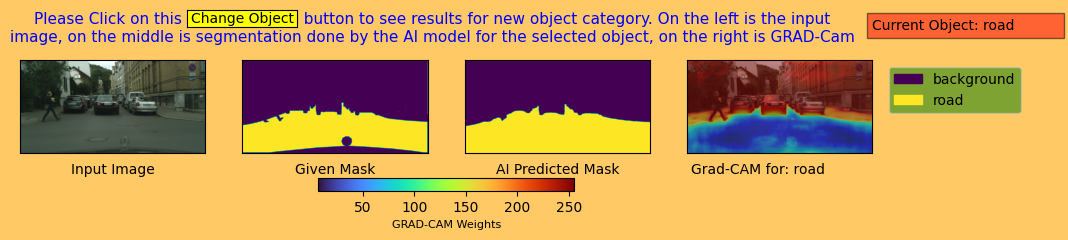

In [38]:
cam_vis(HRNet, MODEL_PATH, layer_name='last_layer',  stop_at=3, 
        data_set=train_set, device=device_rtx3090)